In [1]:

import sys
Lpath = "/work/sfbeltranv/lya-deltas/bin/"
sys.path.append(Lpath)

from Lya_deltas import *

#####################################
# Load QSO from plates (eBoss)
### Parameters
if 0:
   path_drq       = '/work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits'
   path_spec      = '/work3/desi_lya/data/eBOSS/dr15_all/spplates'
   path_out        = '/work/sfbeltranv/output/lya-deltas'
   cat_type       = 'eBoss'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'
else:
# Load QSO from fibers (Desi)
   path_drq      = '/home/sfbeltranv/respaldo/DR14_mini/zcat_m.fits' 
   path_spec     = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16'
   path_out      = '/work/sfbeltranv/output/lya-deltas'
   cat_type      = 'Desi'


# 2 to 4
zmin = 2
zmax = 4.288461538461538

lmin = 1040
lmax = 2000

cont_fit = 'PCA'
#cont_fit = 'lin'

# Catalog load
if ( cat_type == 'eBoss'):
   print(cat_type)
   QSOloc, spectra = load_eBoss(path_drq, path_spec, zmin, zmax, lmin, lmax)
   
elif ( cat_type == 'Desi'):
   print(cat_type)
   QSOloc, spectra = load_Desi(path_drq, path_spec, zmin, zmax, lmin, lmax)
   
else:
   print('Wrong catalog type: '+cat_type)

print( 'Done, loaded '+ str( len(spectra)) +' QSO spec. from catalog.'  )
print( 'Calculating Deltas')

if ( cont_fit == 'PCA'):
   dmodel, pcawave, pcaflux, pcaivar, data_meanspec = get_pca(spectra, 10, 10)
   if 0:     # Calculate cont with current catalog data
      mwave11, mmean11, mstd11, mcoeff11, mcontin_mock = get_continuum( pcawave, dmodel.coeff, dmodel.eigvec, data_meanspec)
   else:     # Load continuum from a 300K QSO catalog
      mwave11 = np.load('wave.npy')
      mmean11 = np.load('meanf.npy')
      mstd11 = np.load('meanstd.npy')
   deltas = getdeltas_PCA(spectra, QSOloc, mwave11, mmean11, mstd11 ) 
            #   wave, delta, ivar, cont  = deltas 
elif ( cont_fit == 'lin'):
   deltas = getdeltas_LinMinimize(spectra, QSOloc )
print( 'Done')

import os
if not os.path.exists(path_out):
    os.makedirs(path_out)

writeDelta( path_out, QSOloc, deltas, cat_type )

   

Desi
Found 167 spectra files.

Found 7624 QSO spec. in 164 files.
0: Loading 71 QSO spec. from file: 0
1: Loading 24 QSO spec. from file: 1
2: Loading 60 QSO spec. from file: 2
3: Loading 14 QSO spec. from file: 3
4: Loading 50 QSO spec. from file: 8
5: Loading 26 QSO spec. from file: 9
6: Loading 51 QSO spec. from file: 10
7: Loading 52 QSO spec. from file: 11
8: Loading 1 QSO spec. from file: 12
9: Loading 30 QSO spec. from file: 14
10: Loading 60 QSO spec. from file: 32
11: Loading 51 QSO spec. from file: 33
12: Loading 49 QSO spec. from file: 34
13: Loading 41 QSO spec. from file: 35
14: Loading 53 QSO spec. from file: 36
15: Loading 27 QSO spec. from file: 37
16: Loading 55 QSO spec. from file: 38
17: Loading 49 QSO spec. from file: 39
18: Loading 43 QSO spec. from file: 40
19: Loading 41 QSO spec. from file: 41
20: Loading 42 QSO spec. from file: 42
21: Loading 40 QSO spec. from file: 43
22: Loading 51 QSO spec. from file: 44
23: Loading 54 QSO spec. from file: 45
24: Loading 55 

/home/sfbeltranv/.bins/empca.py:256: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


       iter        R2             rchi2
EMPCA  1/10       0.00331903      0.00112087
EMPCA  2/10       0.02192565      0.00110414
EMPCA  3/10       0.04296338      0.00108168
EMPCA  4/10       0.05712694      0.00106924
EMPCA  5/10       0.06133009      0.00106572
EMPCA  6/10       0.06303260      0.00106438
EMPCA  7/10       0.06390622      0.00106374
EMPCA  8/10       0.06442638      0.00106337
EMPCA  9/10       0.06476778      0.00106313
EMPCA 10/10       0.06502707      0.00106295
R2: 0.06535624435516219
Done
Writting data from 7624 QSOs
Done writting to file 21.
Done writting to file 36.
Done writting to file 145.
Done writting to file 146.
Done writting to file 147.
Done writting to file 177.
Done writting to file 178.
Done writting to file 179.
Done writting to file 210.
Done writting to file 211.
Done writting to file 212.
Done writting to file 242.
Done writting to file 243.
Done writting to file 274.
Done writting to file 275.
Done writting to file 276.
Done writting to file 

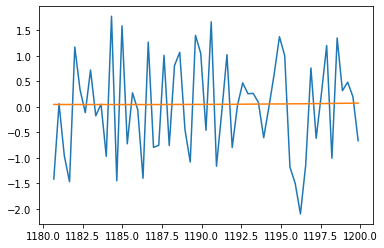

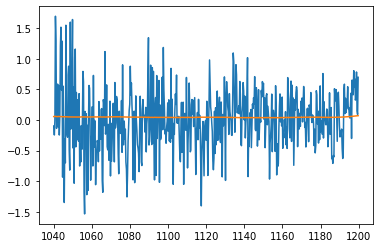

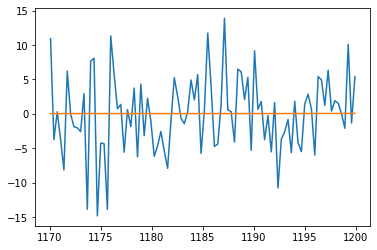

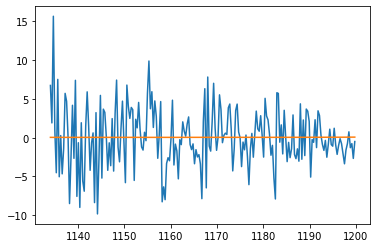

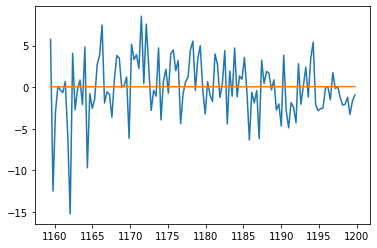

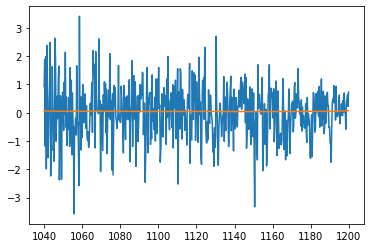

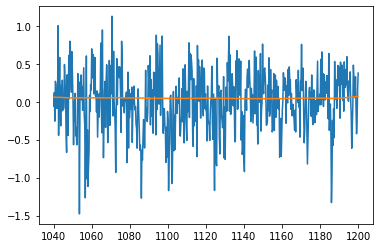

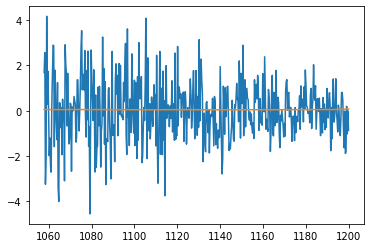

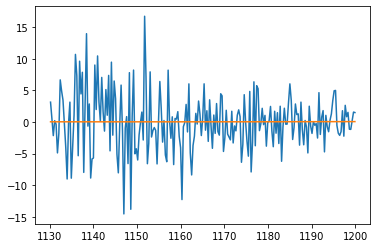

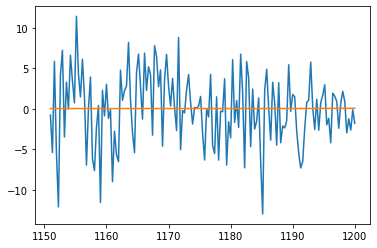

In [3]:
import matplotlib.pyplot as plt

for i in range(0,10):
   plt.figure()
   plt.plot( deltas[i][0]/(1+QSOloc[i][0]), deltas[i][1] )
   plt.plot( deltas[i][0]/(1+QSOloc[i][0]), deltas[i][3] )
   plt.show()
